In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
import os
from os.path import join
import time
import argparse

# inhouse tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

"""
# Fixit
- 


# Todo
- Support other data formats in addition to h5ad
- Change name from scTRS to scdrs
- Add scdrs in front of compute_score
- Implement a memory efficient version

# Finished
- Add --n_ctrl (default value 500) 
- Add --cov_file option to regress out covariates stored in COV_FILE before feeding into the score function 
- Add --ctrl_match_opt='mean_var': use mean- and var- matched control genes 

"""

def convert_species_name(species):
    if species in ['Mouse', 'mouse', 'Mus_musculus', 'mus_musculus', 'mmusculus']:
        return 'mmusculus'
    if species in ['Human', 'human', 'Homo_sapiens', 'homo_sapiens', 'hsapiens']:
        return 'hsapiens'
    raise ValueError('# compute_score: species name %s not supported'%species)

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
sys_start_time = time.time()

###########################################################################################    
######                                    Parse Options                              ######
###########################################################################################    
H5AD_FILE='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/simulation_data/single_cell_data/'\
            'tms_facs.ncell_10k.h5ad'
H5AD_SPECIES='mouse'
COV_FILE='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/tabula_muris_senis/tms_facs.cov'
GS_FILE='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/magma_10kb_1000.60_traits.gs'
GS_SPECIES='human'
CTRL_MATCH_OPT='mean_var'
FLAG_FILTER=True
FLAG_RAW_COUNT=True
# N_CTRL=500
N_CTRL=10000
FLAG_RETURN_CTRL_RAW_SCORE=True
FLAG_RETURN_CTRL_NORM_SCORE=True
OUT_FOLDER='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.schema'

if H5AD_SPECIES!=GS_SPECIES:
    H5AD_SPECIES=convert_species_name(H5AD_SPECIES)
    GS_SPECIES=convert_species_name(GS_SPECIES)

print('# compute_score: H5AD_FILE: ', H5AD_FILE)
print('# compute_score: H5AD_SPECIES: ', H5AD_SPECIES)
print('# compute_score: COV_FILE: ', COV_FILE)
print('# compute_score: GS_FILE: ', GS_FILE)
print('# compute_score: GS_SPECIES: ', GS_SPECIES)
print('# compute_score: CTRL_MATCH_OPT: ', CTRL_MATCH_OPT)
print('# compute_score: FLAG_FILTER: ', FLAG_FILTER)
print('# compute_score: FLAG_RAW_COUNT: ', FLAG_RAW_COUNT)
print('# compute_score: N_CTRL: ', N_CTRL)
print('# compute_score: FLAG_RETURN_CTRL_RAW_SCORE: ', FLAG_RETURN_CTRL_RAW_SCORE)
print('# compute_score: FLAG_RETURN_CTRL_NORM_SCORE: ', FLAG_RETURN_CTRL_NORM_SCORE)
print('# compute_score: OUT_FOLDER: ', OUT_FOLDER)

if CTRL_MATCH_OPT not in ['mean', 'mean_var']:
    raise ValueError('# compute_score: CTRL_MATCH_OPT needs to be one of [mean, mean_var]')

# compute_score: H5AD_FILE:  /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/simulation_data/single_cell_data/tms_facs.ncell_10k.h5ad
# compute_score: H5AD_SPECIES:  mmusculus
# compute_score: COV_FILE:  /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/tabula_muris_senis/tms_facs.cov
# compute_score: GS_FILE:  /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/magma_10kb_1000.60_traits.gs
# compute_score: GS_SPECIES:  hsapiens
# compute_score: CTRL_MATCH_OPT:  mean_var
# compute_score: FLAG_FILTER:  True
# compute_score: FLAG_RAW_COUNT:  True
# compute_score: N_CTRL:  10000
# compute_score: FLAG_RETURN_CTRL_RAW_SCORE:  True
# compute_score: FLAG_RETURN_CTRL_NORM_SCORE:  True
# compute_score: OUT_FOLDER:  /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.schema


In [3]:
###########################################################################################    
######                                     Load data                                 ######
###########################################################################################

# Load .h5ad file 
adata = read_h5ad(H5AD_FILE)
if FLAG_FILTER:
    sc.pp.filter_cells(adata, min_genes=250)
    sc.pp.filter_genes(adata, min_cells=50)
if FLAG_RAW_COUNT:
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
print('# compute_score: H5AD_FILE loaded: n_cell=%d, n_gene=%d'%adata.shape)

# adata = adata[0:500,:].copy()

# Load .cov file and regress out covariates 
if COV_FILE is not None:
    df_cov = pd.read_csv(COV_FILE, sep='\t', index_col=0)
    cov_list = list(df_cov.columns)
    adata.obs.drop([x for x in cov_list if x in adata.obs.columns], axis=1, inplace=True)
    adata.obs = adata.obs.join(df_cov)
    adata.obs.fillna(adata.obs[cov_list].mean(), inplace=True)
    print('# compute_score: COV_FILE loaded, cov_list=%s'%cov_list)

    adata.var['mean'] = adata.X.mean(axis=0).T
    if sp.sparse.issparse(adata.X):
        adata.X = adata.X.toarray()
    adata.X -= adata.var['mean'].values
    adata.X = md.reg_out(adata.X, adata.obs[cov_list].values)
    adata.X += adata.var['mean']
    print('# compute_score: covariates regressed out from adata.X')

# Load .gs file 
df_gs = pd.read_csv(GS_FILE, sep='\t')
df_gs.index = df_gs['TRAIT']
print('# compute_score: GS_FILE loaded: ', df_gs.shape)

# Convert df_gs genes to H5AD_SPECIES genes
if H5AD_SPECIES!=GS_SPECIES:
    # Load homolog file 
    df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                         'mouse_human_homologs.txt', sep='\t')
    if (GS_SPECIES=='hsapiens') & (H5AD_SPECIES=='mmusculus'):
        dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
    elif (GS_SPECIES=='mmusculus') & (H5AD_SPECIES=='hsapiens'):
        dic_map = {x:y for x,y in zip(df_hom['MOUSE_GENE_SYM'], df_hom['HUMAN_GENE_SYM'])}
    else:
        raise ValueError('# compute_score: gene conversion from %s to %s is not supported'%(GS_SPECIES, H5AD_SPECIES))

    for trait in df_gs.index:
        gs_gene_list = df_gs.loc[trait, 'GENESET'].split(',')
        h5ad_gene_list = [dic_map[x] for x in set(gs_gene_list)&set(dic_map.keys())]
        df_gs.loc[trait, 'GENESET'] = ','.join(h5ad_gene_list)
    print('# compute_score: GS_FILE converted from %s to %s genes'%(GS_SPECIES, H5AD_SPECIES))
print('# compute_score: sys_time=%0.1fs'%(time.time()-sys_start_time))

# compute_score: H5AD_FILE loaded: n_cell=10000, n_gene=16715
# compute_score: COV_FILE loaded, cov_list=['const', 'n_genes', 'sex_male', 'age']
# compute_score: covariates regressed out from adata.X
# compute_score: GS_FILE loaded:  (60, 2)
# compute_score: GS_FILE converted from hsapiens to mmusculus genes
# compute_score: sys_time=5.4s


In [4]:
np.random.seed(0)
gene_list = list(np.random.choice(adata.var_names, size=1000, replace=False))
df_gs.loc['all_ngene1000'] = ['all_ngene1000', ','.join(gene_list)]

In [5]:
###########################################################################################    
######                                  Computation                                  ######
###########################################################################################

# Divide genes into mean-var bins
md.compute_stats(adata)
if CTRL_MATCH_OPT=='mean_var':
    v_mean_bin = pd.qcut(adata.var['mean'], 20, labels=False, duplicates='drop')
    adata.var['mean_var'] = ''
    for bin_ in set(v_mean_bin):
        ind_select = (v_mean_bin==bin_)
        v_var_bin = pd.qcut(adata.var.loc[ind_select, 'var'], 20, labels=False, duplicates='drop')
        adata.var.loc[ind_select, 'mean_var'] = ['%s.%s'%(x,y) for x,y in zip(v_mean_bin[ind_select],v_var_bin)]

In [7]:
# # Compute score 
# for trait in ['PASS_IBD_deLange2017', 'UKB_460K.biochemistry_LDLdirect', 
#               'PASS_Schizophrenia_Ruderfer2018', 'all_ngene100']:
#     gene_list = df_gs.loc[trait,'GENESET'].split(',')
#     gene_list = sorted(set(gene_list) & set(adata.var_names))
#     if len(gene_list)<10:
#         print('# %s skipped due to small size (n_gene=%d)'%(trait, len(gene_list)))
#         continue

#     df_res = md.score_cell(adata, gene_list, ctrl_match_key=CTRL_MATCH_OPT, n_ctrl=N_CTRL, 
#                            return_ctrl_raw_score=FLAG_RETURN_CTRL_RAW_SCORE, 
#                            return_ctrl_norm_score=FLAG_RETURN_CTRL_NORM_SCORE, verbose=False,
#                            save_intermediate=OUT_FOLDER+'/%s'%trait)
#     df_res.iloc[:,0:6].to_csv(join(OUT_FOLDER, '%s.score.gz'%trait), sep='\t', index=True, compression='gzip')
#     if FLAG_RETURN_CTRL_RAW_SCORE|FLAG_RETURN_CTRL_NORM_SCORE:
#         df_res.to_csv(join(OUT_FOLDER, '%s.full_score.gz'%trait), sep='\t', index=True, compression='gzip')
#     print('# compute_score: score computed for %s (%d genes), sys_time=%0.1fs'
#           %(trait, len(gene_list), time.time()-sys_start_time))

Trying to set attribute `.X` of view, copying.


# compute_score: score computed for PASS_IBD_deLange2017 (772 genes), sys_time=252.5s


Trying to set attribute `.X` of view, copying.


# compute_score: score computed for UKB_460K.biochemistry_LDLdirect (791 genes), sys_time=467.8s


Trying to set attribute `.X` of view, copying.


# compute_score: score computed for PASS_Schizophrenia_Ruderfer2018 (773 genes), sys_time=681.6s


Trying to set attribute `.X` of view, copying.


# compute_score: score computed for all_ngene100 (1000 genes), sys_time=909.0s


In [7]:
# # Compute score (n_ctrl=10000)
# for trait in ['PASS_IBD_deLange2017', 'UKB_460K.biochemistry_LDLdirect', 
#               'PASS_Schizophrenia_Ruderfer2018', 'all_ngene100']:
#     gene_list = df_gs.loc[trait,'GENESET'].split(',')
#     gene_list = sorted(set(gene_list) & set(adata.var_names))
#     if len(gene_list)<10:
#         print('# %s skipped due to small size (n_gene=%d)'%(trait, len(gene_list)))
#         continue

#     df_res = md.score_cell(adata, gene_list, ctrl_match_key=CTRL_MATCH_OPT, n_ctrl=N_CTRL, 
#                            return_ctrl_raw_score=False, 
#                            return_ctrl_norm_score=False, verbose=False)
#     df_res.iloc[:,0:6].to_csv(join(OUT_FOLDER, '%s.nctrl_10k.score.gz'%trait), 
#                               sep='\t', index=True, compression='gzip')
#     print('# compute_score: score computed for %s (%d genes), sys_time=%0.1fs'
#           %(trait, len(gene_list), time.time()-sys_start_time))

Trying to set attribute `.X` of view, copying.


# compute_score: score computed for PASS_IBD_deLange2017 (772 genes), sys_time=1156.6s


Trying to set attribute `.X` of view, copying.


# compute_score: score computed for UKB_460K.biochemistry_LDLdirect (791 genes), sys_time=2238.8s


Trying to set attribute `.X` of view, copying.


# compute_score: score computed for PASS_Schizophrenia_Ruderfer2018 (773 genes), sys_time=3294.7s


Trying to set attribute `.X` of view, copying.


# compute_score: score computed for all_ngene100 (1000 genes), sys_time=4626.8s


### Make figures 

In [73]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

trait_list = ['PASS_IBD_deLange2017', 'UKB_460K.biochemistry_LDLdirect', 
              'PASS_Schizophrenia_Ruderfer2018', 'all_ngene1000']

dic_plot = {'Raw score': ['raw_score', 'ctrl_raw_score'], 
            'First gene set alignment': ['raw_score.1st_gs_alignment', 'ctrl_raw_score.1st_gs_alignment'], 
            'Cell-wise standardization': ['raw_score.cellwise_standardization',
                                          'ctrl_raw_score.cellwise_standardization'],
            'Second gene set alignment': ['raw_score.2nd_gs_alignment', 'ctrl_raw_score.2nd_gs_alignment'], 
            'Normalized score': ['raw_score.final', 'ctrl_raw_score.final']}

FIG_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_schema'

DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
TRAIT_INFO_FILE=DATA_PATH+'/supp_table/trait_info.tsv'
DF_TRAIT_INFO = pd.read_csv(TRAIT_INFO_FILE, sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
DF_TRAIT_INFO.loc['all_ngene1000', 'Code'] = 'Random-1k'

In [7]:
# Read data 
dic_res = {}
for trait in trait_list:
    dic_res[trait] = pd.read_csv(OUT_FOLDER+'/%s.full_score.gz'%trait, sep='\t', index_col=0)
    dic_res['%s_10k'%trait] = pd.read_csv(OUT_FOLDER+'/%s.nctrl_10k.score.gz'%trait, sep='\t', index_col=0)
    
dic_inter_res = {}
for file in os.listdir(OUT_FOLDER):
    if 'raw_score' in file:
        dic_inter_res[file.replace('.tsv.gz', '')] = np.loadtxt(OUT_FOLDER+'/'+file)

# trait_std=1.78e-02, ctrl_mean_std=1.14e-03, ratio=6.39e-02


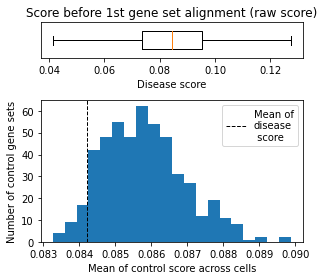

# trait_std=1.78e-02, ctrl_mean_std=1.39e-02, ratio=7.80e-01
# trait_std=1.78e-02, ctrl_std_mean=9.43e-03, ratio=5.29e-01


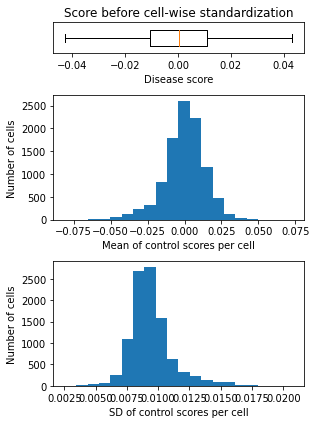

# trait_std=1.28e+00, ctrl_mean_std=1.26e-02, ratio=9.80e-03


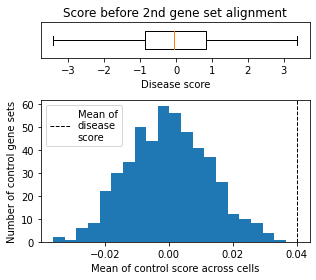

In [8]:
# Figures 
trait = trait_list[0]
    
# Raw score 
term = 'Raw score'
trait_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])].std()
ctrl_mean_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].mean(axis=0).std()
print('# trait_std=%0.2e, ctrl_mean_std=%0.2e, ratio=%0.2e'%(trait_std, ctrl_mean_std, ctrl_mean_std/trait_std))
plt.figure(figsize=[4.5,4])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 
ax0 = plt.subplot(gs[0])
plt.title('Score before 1st gene set alignment (raw score)')
ax0.boxplot(dic_inter_res['%s.%s'%(trait, dic_plot[term][0])], widths=0.5, vert=False, showfliers=False)
plt.xlabel('Disease score')
plt.yticks([],[])
# plt.xticks([], [])
ax1 = plt.subplot(gs[1])
trait_mean = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])].mean()
v_ctrl_mean = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].mean(axis=0)
ax1.hist(v_ctrl_mean, bins=20)
ymin,ymax = plt.ylim()
plt.plot([trait_mean, trait_mean], [ymin,ymax], linestyle='--', linewidth=1, 
         color='k', label='Mean of\ndisease\n score')
# plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.legend()
plt.xlabel('Mean of control score across cells')
plt.ylabel('Number of control gene sets')
plt.tight_layout()
plt.savefig(FIG_PATH+'/step.raw_score.gs_mean.%s.svg'%trait)
plt.show()

# Effects of First gene set alignment
term = 'First gene set alignment'
trait_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])].std()
ctrl_mean_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].mean(axis=1).std()
print('# trait_std=%0.2e, ctrl_mean_std=%0.2e, ratio=%0.2e'%(trait_std, ctrl_mean_std, ctrl_mean_std/trait_std))
trait_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])].std()
ctrl_std_mean = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].std(axis=1).mean()
print('# trait_std=%0.2e, ctrl_std_mean=%0.2e, ratio=%0.2e'%(trait_std, ctrl_std_mean, ctrl_std_mean/trait_std))
plt.figure(figsize=[4.5,6])
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 4, 4]) 
ax0 = plt.subplot(gs[0])
plt.title('Score before cell-wise standardization')
ax0.boxplot(dic_inter_res['%s.%s'%(trait, dic_plot[term][0])], widths=0.5, vert=False, showfliers=False)
xmin,xmax = plt.xlim()
plt.xlabel('Disease score')
plt.yticks([],[])
ax1 = plt.subplot(gs[1])
v_ctrl_mean_percell = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].mean(axis=1)
ax1.hist(v_ctrl_mean_percell, bins=20)
plt.xlabel('Mean of control scores per cell')
plt.ylabel('Number of cells')
ax2 = plt.subplot(gs[2])
v_ctrl_sd_percell = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].std(axis=1)
ax2.hist(v_ctrl_sd_percell, bins=20)
plt.xlabel('SD of control scores per cell')
plt.ylabel('Number of cells')
plt.tight_layout()
plt.savefig(FIG_PATH+'/step.score_after_1st_gs_alignment.cellwise_stats.%s.svg'%trait)
plt.show()


# Cell-wise standardization
term = 'Cell-wise standardization'
trait_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])].std()
ctrl_mean_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].mean(axis=0).std()
print('# trait_std=%0.2e, ctrl_mean_std=%0.2e, ratio=%0.2e'%(trait_std, ctrl_mean_std, ctrl_mean_std/trait_std))
plt.figure(figsize=[4.5,4])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 
ax0 = plt.subplot(gs[0])
plt.title('Score before 2nd gene set alignment')
ax0.boxplot(dic_inter_res['%s.%s'%(trait, dic_plot[term][0])], widths=0.5, vert=False, showfliers=False)
plt.xlabel('Disease score')
plt.yticks([],[])
# plt.xticks([], [])
ax1 = plt.subplot(gs[1])
trait_mean = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])].mean()
v_ctrl_mean = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].mean(axis=0)
ax1.hist(v_ctrl_mean, bins=20)
ymin,ymax = plt.ylim()
plt.plot([trait_mean, trait_mean], [ymin,ymax], linestyle='--', linewidth=1, 
         color='k', label='Mean of\ndisease\nscore')
# plt.xlim([xmin,xmax])
plt.ylim([ymin, ymax])
plt.legend(loc='upper left')
plt.xlabel('Mean of control score across cells')
plt.ylabel('Number of control gene sets')
plt.tight_layout()
plt.savefig(FIG_PATH+'/step.score_after_cw_std.gs_mean.%s.svg'%trait)
plt.show()

# Second gene set alignment
term = 'Second gene set alignment'


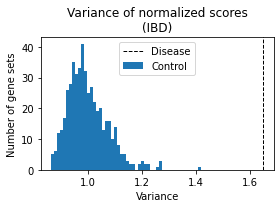

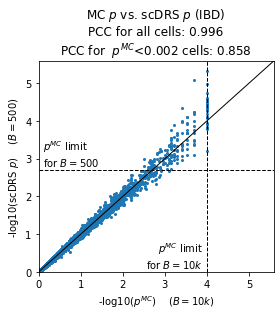

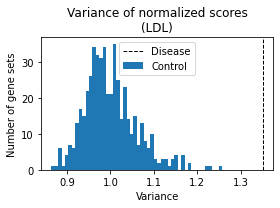

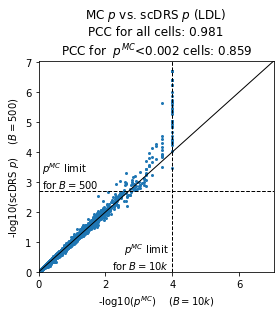

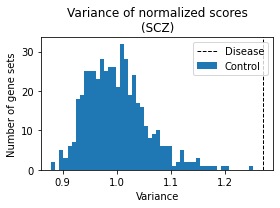

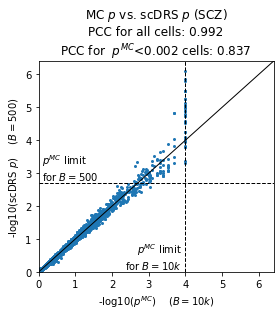

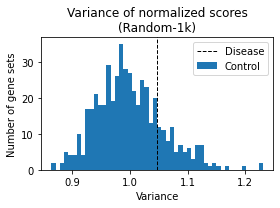

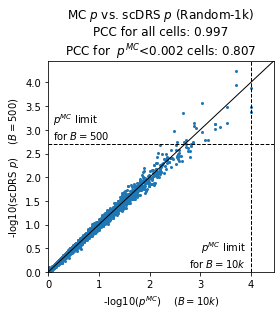

In [116]:
# Validations 
for trait in trait_list:    
    
    # Variance of disease score and control scores 
    plt.figure(figsize=[4,3])
    v_ctrl_std = dic_inter_res['%s.%s'%(trait, dic_plot['Normalized score'][1])].var(axis=0)
    trait_std = dic_res[trait]['norm_score'].var()
    plt.hist(v_ctrl_std, bins=50, label='Control')
    ymin,ymax = plt.ylim()
    plt.plot([trait_std, trait_std], [ymin,ymax], 
             linestyle='--', linewidth=1, color='k', label='Disease')
    plt.legend()
    plt.ylim([ymin, ymax])   
    plt.xlabel('Variance')
    plt.ylabel('Number of gene sets')
    plt.title('Variance of normalized scores\n(%s)'%DF_TRAIT_INFO.loc[trait, 'Code'])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/var_norm_score.%s.svg'%trait)
    plt.show()
    
    # Consistency between mc_pval and pval
    plt.figure(figsize=[4,4.5])
    v_mc_p = dic_res['%s_10k'%trait]['mc_pval']
    v_pooled_p = dic_res[trait]['pval']
    plt.scatter(-np.log10(v_mc_p), -np.log10(v_pooled_p), s=4)
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    xmin,ymin = 0,0
    min_,max_ = min(xmin,ymin), max(xmax,ymax)
    plt.plot([min_,max_], [min_,max_], linestyle='-', linewidth=1, color='k')
    plt.plot([min_,max_], [-np.log10(1/501),-np.log10(1/501)], linestyle='--', linewidth=1, color='k')
    plt.text(0.1, -np.log10(1/501)+0.1, '$p^{MC}$ limit\nfor $B=500$')
    plt.plot([-np.log10(1/10001),-np.log10(1/10001)], [min_,max_], linestyle='--', linewidth=1, color='k')
    plt.text(-np.log10(1/10001)-0.1, 0.1, '$p^{MC}$ limit\nfor $B=10k$', ha='right')
    plt.xlim([min_, max_])   
    plt.ylim([min_, max_])   
    plt.xlabel('-log10($p^{MC}$)    ($B=10k)$')
    plt.ylabel('-log10(scDRS $p$)    ($B=500$)')
    corr_ = np.corrcoef(-np.log10(v_mc_p), -np.log10(v_pooled_p))[0,1]    
    ind_select = (v_mc_p<1/500)
    corr_extra = np.corrcoef(-np.log10(v_mc_p[ind_select]), -np.log10(v_pooled_p[ind_select]))[0,1]    
    plt.title('MC $p$ vs. scDRS $p$ (%s)\nPCC for all cells: %0.3f\nPCC for  $p^{MC}$<0.002 cells: %0.3f'
              %(DF_TRAIT_INFO.loc[trait, 'Code'], corr_, corr_extra))
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/mcp_vs_p.%s.svg'%trait)
    plt.show()
    
#     # Inconsistency between mc_pval and pval.raw
#     term = 'First gene set alignment'
# #     term = 'Cell-wise standardization'
#     v_raw_score = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])]
#     mat_ctrl_raw_score = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])]
#     v_pooled_p = md._get_p_from_empi_null(v_raw_score, mat_ctrl_raw_score.flatten())
    
#     plt.figure(figsize=[4,4.5])
#     v_mc_p = dic_res['%s_10k'%trait]['mc_pval']
#     plt.scatter(-np.log10(v_mc_p), -np.log10(v_pooled_p), s=4)
#     xmin,xmax = plt.xlim()
#     ymin,ymax = plt.ylim()
#     xmin,ymin = 0,0
#     min_,max_ = min(xmin,ymin), max(xmax,ymax)
#     plt.plot([min_,max_], [min_,max_], linestyle='-', linewidth=1, color='k')
#     plt.plot([min_,max_], [-np.log10(1/501),-np.log10(1/501)], linestyle='--', linewidth=1, color='k')
#     plt.text(0.1, -np.log10(1/501)+0.1, '$p^{MC}$ limit\nfor $B=500$')
#     plt.plot([-np.log10(1/10001),-np.log10(1/10001)], [min_,max_], linestyle='--', linewidth=1, color='k')
#     plt.text(-np.log10(1/10001)-0.1, 0.1, '$p^{MC}$ limit\nfor $B=10k$', ha='right')
#     plt.xlim([min_, max_])   
#     plt.ylim([min_, max_])   
#     plt.xlabel('-log10($p^{MC}$)    ($B=10k)$')
#     plt.ylabel('-log10(scDRS $p$)    ($B=500$)')
#     corr_ = np.corrcoef(-np.log10(v_mc_p), -np.log10(v_pooled_p))[0,1]    
#     ind_select = (v_mc_p<1/500)
#     corr_extra = np.corrcoef(-np.log10(v_mc_p[ind_select]), -np.log10(v_pooled_p[ind_select]))[0,1]    
#     plt.title('MC $p$ vs. scDRS $p$ (%s)\nPCC for all cells: %0.3f\nPCC for  $p^{MC}$<0.002 cells: %0.3f'
#               %(DF_TRAIT_INFO.loc[trait, 'Code'], corr_, corr_extra))
#     plt.tight_layout()
#     plt.savefig(FIG_PATH+'/mcp_vs_p.raw_score.%s.svg'%trait)
#     plt.show()

In [117]:
FIG_PATH

'/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_schema'